# Intro to Regression 02

## Stock Prediction

### Your name :     

### Kaggle Link for exercise :
* [Stock Price trend Prediction dataset](https://www.kaggle.com/aumashe/stock-ew/home) : Historical stock prices of Edwards Lifesciences Corporation (EW) 2000-03-26 ~ 2017-09-09

### Real Data for exercise :
* [내가 원하는 회사 데이터 다운 받을 곳!](https://finance.yahoo.com/quote/005930.KS/history?p=005930.KS&.tsrc=fin-srch-v1)
![how-to](https://github.com/RayleighKim/Example_datasets/blob/master/yahoo_finance.PNG?raw=true)

#### 실습목표<br>
1. LSTM의 코드 구조를 이해한다.
2. Feature Engineering을 통해 성능을 높여본다.
3. 실제 관심있는 회사의 주가를 관찰해본다.

---------------
Rayleigh Kim


In [3]:
'''
matplolib inline 명령어를 통해서
matplot으로 그리는 플롯들을 주피터 노트북 내에서 볼 수 있게 해준다.
포맷을 retina로 바꾸면 그래프의 화질이 훨씬 좋아진다.
'''
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

'''
라이브러리들을 불러오자.
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend as k

from sklearn.metrics import mean_squared_error, r2_score


Using TensorFlow backend.


## Load and Prepare the data

In [0]:
data_path = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Stock_Edwards_Lifesciences_corporation.csv'
stock = pd.read_csv(data_path)

In [0]:
# '''
# Stock_Edwards_Lifesciences_corportation.csv 를 업로드 하자.
# '''
# from google.colab import files
# files.upload

In [0]:
# stock = pd.read_csv('Stock_Edwards_Lifesciences_corporation.csv')

In [5]:
print(stock.shape)
stock.head()

(4392, 7)


,Date,Open,High,Low,Close,Adj_Close,Volume
0,2000/3/27,3.812500,4.156250,3.812500,4.125000,4.125000,3675600
1,2000/3/28,4.125000,4.125000,4.000000,4.015625,4.015625,1077600
2,2000/3/29,4.000000,4.031250,3.953125,4.000000,4.000000,437200
3,2000/3/30,4.000000,4.000000,3.843750,3.843750,3.843750,1883600
4,2000/3/31,3.734375,3.734375,3.390625,3.390625,3.390625,7931600


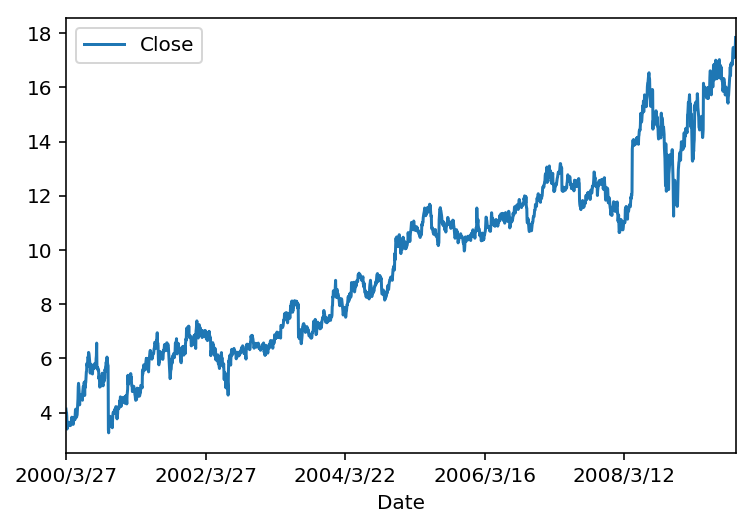

In [7]:
stock[:2400].plot(x='Date', y='Close')

### Drop columns

* 사용하지 않을 변수들은 제거하자.
* 컬럼을 사용하기 좋은 순서대로 바꾸자.



In [8]:
fields_to_drop = ['Date', 'Adj_Close']
data = stock.drop(fields_to_drop, axis=1)
data = data[['Open', 'High', 'Low', 'Volume','Close']]

data.head()

,Open,High,Low,Volume,Close
0,3.812500,4.156250,3.812500,3675600,4.125000
1,4.125000,4.125000,4.000000,1077600,4.015625
2,4.000000,4.031250,3.953125,437200,4.000000
3,4.000000,4.000000,3.843750,1883600,3.843750
4,3.734375,3.734375,3.390625,7931600,3.390625


### Scaling target variables

mean shifting & Scaling : 평균을 0으로, 표준편차를 1로<br>
사실 scikit-learn에서 한방에 하는 방법도 있다.<br>
[Missing-Value처리](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html), [StandardScaling](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)<br>
연습삼아 직접 해보자!



In [0]:
quant_features = list(data)
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [10]:
'''
위에서 쓰인 Dictionary 잠깐 짚어보기.
Dictionary의 각각의 원소는 key : value 쌍으로 되어 있다.
'''

scaled_features

{'Close': [30.57258004553734, 29.90577823724551],
 'High': [30.89361788706736, 30.21097443352821],
 'Low': [30.238833208105614, 29.615760842781114],
 'Open': [30.56253900660293, 29.914758292353216],
 'Volume': [1884027.140255009, 1621608.7572348083]}

### Pandas Dataframe to Numpy array



In [11]:
xy = data.values
print(xy[:5])

[[-8.94208763e-01 -8.85021698e-01 -8.92306409e-01  1.10481203e+00
  -8.84363545e-01]
 [-8.83762414e-01 -8.86056090e-01 -8.85975321e-01 -4.97300682e-01
  -8.88020865e-01]
 [-8.87940954e-01 -8.89159267e-01 -8.87558093e-01 -8.92217148e-01
  -8.88543339e-01]
 [-8.87940954e-01 -8.90193659e-01 -8.91251228e-01 -2.63405247e-04
  -8.93768082e-01]
 [-8.96820350e-01 -8.98985994e-01 -9.06551358e-01  3.72936618e+00
  -9.08919836e-01]]


## Wrong Case I : Linear Regression

y_data가 어떻게 생성되었는지 잘 보라.

In [0]:
k.clear_session()
### Split
x_data = xy[:, 0:-1]
y_data = xy[:, [-1]]

x_train, x_valid, x_test = x_data[:-30], x_data[-30:-10], x_data[-10:]
y_train, y_valid, y_test = y_data[:-30], y_data[-30:-10], y_data[-10:]

### modeling
model = Sequential()
model.add(Dense(units =   1, input_dim=x_data.shape[1]))
model.compile(loss='mse', optimizer = 'adam', metrics = ['mse'] )

### Training


model.fit(x_train, y_train, batch_size = 512,
         epochs = 1000, validation_data=(x_valid, y_valid),
          callbacks=[EarlyStopping(monitor='val_loss', patience=15)]
         )

### evaluate

pred_train = model.predict(x_train)
pred_valid = model.predict(x_valid)
pred_test = model.predict(x_test)

print("Mean Squared Error on Training set : {0:.5f}".format(mean_squared_error(y_train, pred_train)  ))
print("Mean Squared Error on Validation set : {0:.5f}".format(mean_squared_error(y_valid, pred_valid)  ))
print("Mean Squared Error on Test set : {0:.5f}".format(mean_squared_error(y_test, pred_test)  ))

print("R-squared Score on Training set : {0:.5f}".format(r2_score(y_train, pred_train)))
print("R-squared Score on Validation set : {0:.5f}".format(r2_score(y_valid, pred_valid)))
print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test, pred_test)))

fig, ax = plt.subplots(figsize=(10,5))

# 예측값도 Scaling 되어 있으므로 그것을 원래대로 되돌려주는 과정
mean, std = scaled_features['Close']

ax.plot((pred_test)*std+mean, label = 'Prediction')
ax.plot((y_test)*std+mean, label = 'Real')
ax.set_xlim(right = len(y_test))
ax.legend()


## Wrong Case II : Linear Regression

1. 앞의 case와 비교하여 y_data는 어떻게 생성되었는가?
2. 무엇이 잘못되었는가?

In [0]:
k.clear_session()

### Split to predict tomorrow
x_data = xy[:-1]
y_data = xy[1:, [-1]]

x_train, x_valid, x_test = x_data[:-30], x_data[-30:-10], x_data[-10:]
y_train, y_valid, y_test = y_data[:-30], y_data[-30:-10], y_data[-10:]

### modeling
model = Sequential()
model.add(Dense(units =   1, input_dim=x_data.shape[1]))
model.compile(loss='mse', optimizer = 'adam', metrics = ['mse'] )

### Training


model.fit(x_train, y_train, batch_size = 512,
         epochs = 1000, validation_data=(x_valid, y_valid),
          callbacks=[EarlyStopping(monitor='val_loss', patience=15)]
         )

### evaluate

pred_train = model.predict(x_train)
pred_valid = model.predict(x_valid)
pred_test = model.predict(x_test)

print("Mean Squared Error on Training set : {0:.5f}".format(mean_squared_error(y_train, pred_train)  ))
print("Mean Squared Error on Validation set : {0:.5f}".format(mean_squared_error(y_valid, pred_valid)  ))
print("Mean Squared Error on Test set : {0:.5f}".format(mean_squared_error(y_test, pred_test)  ))

print("R-squared Score on Training set : {0:.5f}".format(r2_score(y_train, pred_train)))
print("R-squared Score on Validation set : {0:.5f}".format(r2_score(y_valid, pred_valid)))
print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test, pred_test)))

fig, ax = plt.subplots(figsize=(10,5))

# 예측값도 Scaling 되어 있으므로 그것을 원래대로 되돌려주는 과정
mean, std = scaled_features['Close']

ax.plot((pred_test)*std+mean, label = 'Prediction')
ax.plot((y_test)*std+mean, label = 'Real')
ax.set_xlim(right = len(y_test))
ax.legend()


## Just Not Bad Case : LSTM

In [0]:
from keras.layers import Activation
from keras.layers import LSTM
from keras.layers import Flatten







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 8)              448       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 661
Trainable params: 661
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 4354 samples, validate on 20 samples
Epoch 1/1000
4354/4354 [==============================] - 5s 1ms/step - loss: 0.9789 - val_loss: 7.9738
Epoc

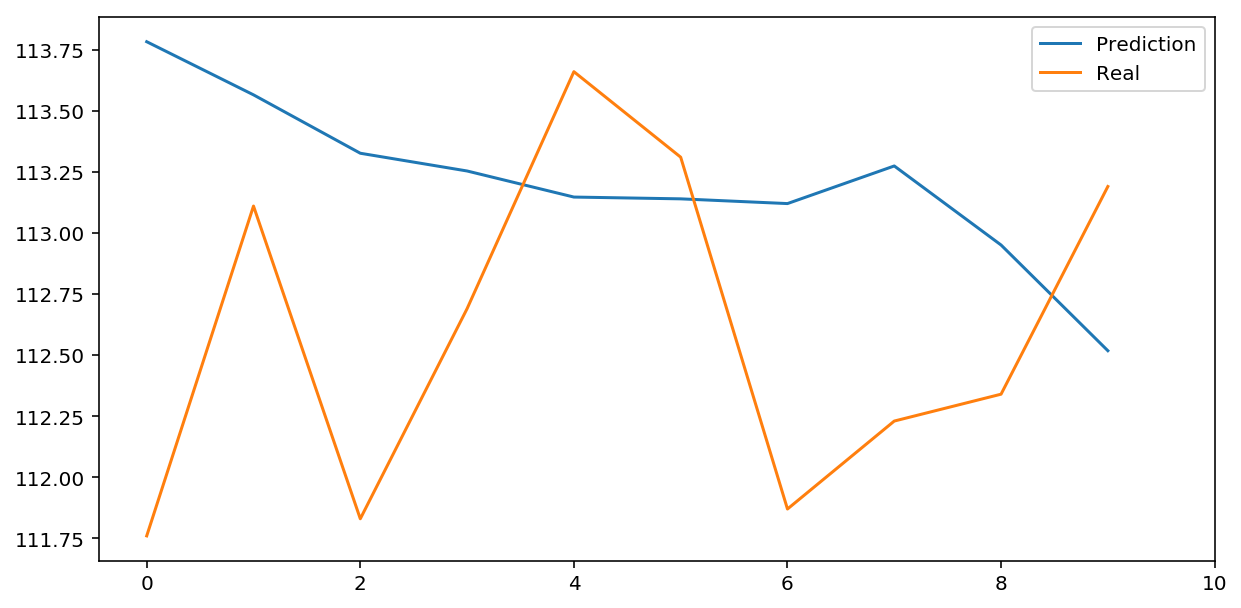

In [13]:
k.clear_session()

### Hyper-parameters

timesteps = seq_len = 7
data_dim = 5


### Split to predict tomorrow
x_data = xy
y_data = xy[1:, [-1]]

x_data_seq = []
y_data_seq = []

for i in range(0, len(y_data)-seq_len) :
    x_data_seq.append(x_data[i:i+seq_len])
    y_data_seq.append(y_data[i+seq_len])

x_data_seq = np.array(x_data_seq)
y_data_seq = np.array(y_data_seq)
    
x_train, x_valid, x_test = x_data_seq[:-30], x_data_seq[-30:-10], x_data_seq[-10:]
y_train, y_valid, y_test = y_data_seq[:-30], y_data_seq[-30:-10], y_data_seq[-10:]

### modeling
model = Sequential()
model.add(LSTM(8, input_shape = (seq_len, data_dim),return_sequences=True))
model.add(LSTM(4, return_sequences=False))
# model.add(Flatten())
model.add(Dense(1))
model.add(Activation("linear"))

model.compile(loss='mse', optimizer = 'adam')
model.summary()
### Training


model.fit(x_train, y_train, batch_size = 512,
         epochs = 1000, validation_data=(x_valid, y_valid),
          callbacks=[EarlyStopping(monitor='val_loss', patience=15)]
         )

### evaluate

pred_train = model.predict(x_train)
pred_valid = model.predict(x_valid)
pred_test = model.predict(x_test)

print("Mean Squared Error on Training set : {0:.5f}".format(mean_squared_error(y_train, pred_train)  ))
print("Mean Squared Error on Validation set : {0:.5f}".format(mean_squared_error(y_valid, pred_valid)  ))
print("Mean Squared Error on Test set : {0:.5f}".format(mean_squared_error(y_test, pred_test)  ))

print("R-squared Score on Training set : {0:.5f}".format(r2_score(y_train, pred_train)))
print("R-squared Score on Validation set : {0:.5f}".format(r2_score(y_valid, pred_valid)))
print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test, pred_test)))

fig, ax = plt.subplots(figsize=(10,5))

# 예측값도 Scaling 되어 있으므로 그것을 원래대로 되돌려주는 과정
mean, std = scaled_features['Close']

ax.plot((pred_test)*std+mean, label = 'Prediction')
ax.plot((y_test)*std+mean, label = 'Real')
ax.set_xlim(right = len(y_test))
ax.legend()
